In [12]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("../../data/csv/User_acitive.csv")
df = df.drop('author.1', axis=1)
df.head()

,author,num_posts,total_num_comments,total_score
0,TheSkoko,1,14,0
1,TheGreatDarkPriest,39,353,4479
2,alastrasix,1,2,1
3,AzureNebula,1,0,1
4,Aggravating_Trade407,1,0,1


Sort the dataframe according to the author, we can see that there are huge amount posts that author name are deleted. Therefore remove the deleted authors

In [3]:
df.sort_values(by='num_posts', ascending=False).head()

,author,num_posts,total_num_comments,total_score
31,[deleted],1197668,4704583,18347237
173037,AutoModerator,5024,453487,33031
1226246,DTG_Bot,3307,603964,456106
1046331,Ectophial1,1801,3375,3845
873276,ineeeit-finder,1779,0,1779


In [4]:
df_nodelete = df[df["author"] != "[deleted]"]
df_nodelete.sort_values(by='num_posts', ascending=False).head()

,author,num_posts,total_num_comments,total_score
173037,AutoModerator,5024,453487,33031
1226246,DTG_Bot,3307,603964,456106
1046331,Ectophial1,1801,3375,3845
873276,ineeeit-finder,1779,0,1779
526763,Cocha_Gamer,1647,0,1647


check the number of rows of the dataframe, we can see that there are so many authors. Therefore, filter the data that the author has post more than 1 reddits, and the total number of comments the author got is more than 1, and the total score is more than 1.

In [6]:
len(df_nodelete)

1441859

In [7]:
df_use = df_nodelete[(df_nodelete['num_posts'] > 1) & (df_nodelete['total_num_comments'] > 1) & (df_nodelete['total_score'] > 1)]
len(df_use)

456730

In [29]:
df_use.sort_values(by='total_num_comments', ascending=False).head()

,author,num_posts,total_num_comments,total_score
172864,Veritasibility,1140,3077033,85120
1226246,DTG_Bot,3307,603964,456106
173037,AutoModerator,5024,453487,33031
435,PokeUpdateBot,753,135988,16387
814,Juil8991MC,915,93463,142023


In [30]:
df_use.describe()

,num_posts,total_num_comments,total_score
count,456730.000000,4.567300e+05,4.567300e+05
mean,6.029724,9.823831e+01,1.054450e+03
std,17.615734,4.713256e+03,7.996819e+03
min,2.000000,2.000000e+00,2.000000e+00
25%,2.000000,7.000000e+00,5.000000e+00
50%,3.000000,1.700000e+01,1.800000e+01
75%,6.000000,5.100000e+01,1.380000e+02
max,5024.000000,3.077033e+06,1.740051e+06


Perform Kmean clustering

In [8]:
# Extract features for clustering
features = df_use[['num_posts', 'total_num_comments', 'total_score']]

# Standardize the features
scaler = StandardScaler()
X= scaler.fit_transform(features)

In [9]:
k_means_4 = KMeans(n_clusters=4, random_state=42)
# labels=kmeans.fit_predict(X)
model = k_means_4.fit(X)
labels = k_means_4.labels_
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

c:\Users\84160\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.9743992659411637


Create a new column Cluster to record the labels respectively

In [34]:
data_copy=features.copy()
data_copy['Cluster']=labels

# Define the mapping rules
mapping = {0: "not active", 1: "low influence", 2: "very influential", 3: "high influence"}
# Apply the mapping to the 'Cluster4' column
data_copy['Cluster'] = data_copy['Cluster'].map(mapping)

data_copy.head()

,num_posts,total_num_comments,total_score,Cluster
1,39,353,4479,not active
5,4,7,21,not active
6,18,600,2917,not active
11,1054,3269,1551,low influence
14,3,45,221,not active


Plot the scatterplot that shows the relationship total number of comments and the total score based on the different clusters.

Text(0, 0.5, 'Total Score')

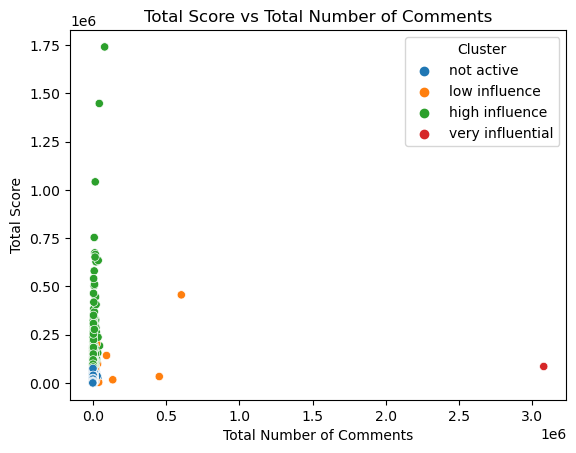

In [36]:
sns.scatterplot(data=data_copy,x='total_num_comments',y='total_score',hue='Cluster')
plt.title('Total Score vs Total Number of Comments')
plt.xlabel('Total Number of Comments')
plt.ylabel('Total Score')


In [40]:
table = data_copy.groupby('Cluster').agg({'num_posts': 'min', 'total_num_comments':'min', 'total_score': 'min'})
table['Number of authors'] = data_copy['Cluster'].value_counts()
table

,num_posts,total_num_comments,total_score,Number of authors
Cluster,,,,
high influence,2,454,73919,509
low influence,194,2,202,360
not active,2,2,2,455860
very influential,1140,3077033,85120,1


low influencial 就说虽然有很多comments，但是没有特别多的score，所以可能并不代表会影响别人（别人赞同你的观点），可能一些有争议的话，会导致很多的评论。再或者有争议的评论会导致很多人在你的posts下面进行讨论，就导致了你的total number of comments 高。
因为score高就代表你获得的赞同比较高。

we can see that there is a group that only has 1 author since his posts has huge amount of comments. This may because of some of his posts are highly controversial, there are huge amount of debates under some of the posts. Therefore remove this author to evaluate.

In [43]:
data_use = data_copy[data_copy["Cluster"] != "very influential"]

456729

Text(0, 0.5, 'Total Score')

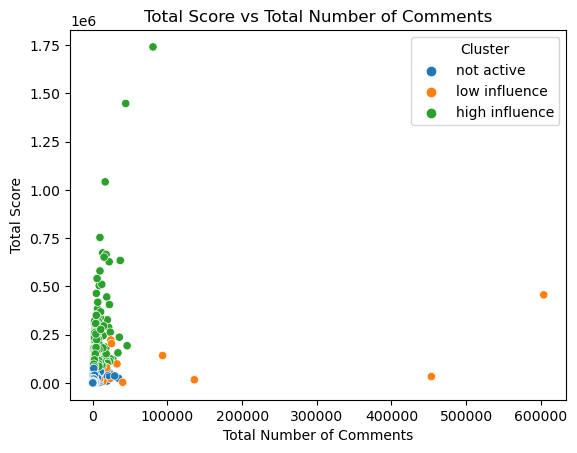

In [45]:
sns.scatterplot(data=data_use,x='total_num_comments',y='total_score',hue='Cluster')
plt.title('Total Score vs Total Number of Comments')
plt.xlabel('Total Number of Comments')
plt.ylabel('Total Score')


In [48]:
table = data_use.groupby('Cluster').agg({'num_posts': 'min', 'total_num_comments':'min', 'total_score': 'min'})
table['Number of authors'] = data_copy['Cluster'].value_counts()
table

,num_posts,total_num_comments,total_score,Number of authors
Cluster,,,,
high influence,2,454,73919,509
low influence,194,2,202,360
not active,2,2,2,455860
